In [39]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Integration using Hermite Individual Timestep Scheme (HITS)

In [40]:
G = 6.67e-11 #graviational constant, SI units
m = 1 #mass
epsilon = 0.001 #softening parameter

In [41]:
def initialize(N):
    
    """This function initializes a set of positions for N number of stars."""
    
    r=np.zeros((N,3))
    for i in range(0,N):
        r[i] = np.random.normal(0, 1, 3) #centered at origin, standard deviation of 1, size
        
    return r

In [51]:
N = 100 # number of stars
r0=initialize(N)

In [52]:
#get velocity from position using Kepler's Third Law

def get_velocity(r):
    
    """This function takes an array of position components for individual stars and finds
    the period using Kepler's Third Law, and then finds velocity using T=2piR/v"""
    
    v=np.zeros(r.shape)
    period_array = np.zeros(r.shape)
    for i in range(0,len(r)): #iterate through each set of position components
        radius = np.linalg.norm(r[i])  #get total radius
        #get period from radius, then get velocity
        period_array[i] = np.sqrt((4*(np.pi)/(G*m))*np.absolute(radius**3))
        v[i] = (2*np.pi*(radius)/period_array[i])
        
    return np.array(v) 
    

In [53]:
# force calculation
def force_calc(pos, vel, index):

    """This function evaluates the acceleration and jerk for a specific star using
    equation 2 in Aarseth & Makino. It takes the position, velocity, and index of the star."""
    
   
    accels=np.zeros((len(pos),3))
    jerks = np.zeros((len(pos),3))
    
    #for each particle, need to loop over all other particles to calculate acceleration
    #here "index" is i in the equation and "star" is j in the equation from Aarseth and Makino
    for star in range(0, len(pos)):
        if star != index:
            mag = np.linalg.norm(pos[star] - pos[index])
            accels[star] = G*m*(pos[star] - pos[index])/((mag)**2 + epsilon*mag)**(3/2)
            jerks[star] = G*m*((vel[star] - vel[index])/(mag**2 + (epsilon*mag)**2)**(3/2) 
                + (3*(np.dot(vel[star] - vel[index],pos[star] - pos[index]))*(pos[star] - pos[index]))/(mag**2 
                                                                            + (epsilon*mag)**2)**(5/2))
            
    return np.sum(accels,axis=0), np.sum(jerks,axis=0)

In [54]:
def prediction(pos, vel, index):
    
    """This function takes in the initial positions and velocities, calls the force_calc function 
    to get a prediction of the initial acceleration, then predicts the next position and velocity of the particle
    using Equation 1 in the Aarseth and Makino paper."""
    
    r_pred = pos[index] + vel[index]*dt + (1/2)*(force_calc(pos,vel,index)[0])*dt**2 
    + (1/6)*(force_calc(pos,vel,index)[1])*dt**3
    v_pred = vel[index] + (force_calc(pos,vel,index)[0])*dt + (1/2)*(force_calc(pos,vel,index)[1])*dt**2
    
    return r_pred, v_pred
    

In [55]:
# second derivative of acceleration
def second_deriv(pos0, vel0, index): #make inputs accel and jerk
    second_deriv = ((-6)*(force_calc(pos0,vel0,index)[0] - force_calc(pos0, vel0, index)[0]) 
                    - dt*(4*force_calc(pos0,vel0,index)[1] + 2*force_calc(pos0,vel0,index)[1]))/(dt**2) 
    return second_deriv

#third derivative of acceleration
def third_deriv(pos0, vel0, index):
    third_deriv = ((-12)*(force_calc(pos0,vel0,index)[0] - force_calc(pos0, vel0, index)[0]) 
                   - 6*dt*(force_calc(pos0,vel0,index)[1] + force_calc(pos0,vel0,index)[1]))/(dt**3)
    
    return third_deriv


#third-order hermite interpolation polynomial
def interpol_polynomial(pos0, vel0,index):
    
    """This function takes the initial positions and velocities and 
    uses Equation 4 in Aarseth & Makino to get the third-order Hermite interpolation polynomial."""
    
    inter_poly =  force_calc(pos0, vel0,index)[0] + force_calc(pos0, vel0,index)[1] 
    + (1/2)*(dt**2)*(second_deriv(pos0, vel0, index)) + (1/6)*(dt**3)*(third_deriv(pos0,vel0,index))
    
    return inter_poly

#position and velocity correction 

def correction(pos0, vel0, index): #change inputs
    
    """This function takes the initial positions and velocities, and uses 
    Equation 6 in Aarseth & Makino to get the corrected position and velocities."""
    r_correct = prediction(pos0,vel0,index)[0] + (1/24)*(dt**4)*(second_deriv(pos0,vel0,index)) 
    + (1/120)*(dt**5)*(third_deriv(pos0,vel0,index))
    
    v_correct = prediction(pos0, vel0, index)[1] + (1/4)*(dt**3)*(second_deriv(pos0,vel0,index))
    + (1/24)*(dt**4)*third_deriv(pos0, vel0, index)
    
    return r_correct, v_correct


In [56]:
#initial time step, need this for initial calculations, equation 9 from Aarseth & Makino
eta_s = 0.01 #from Aarseth and Makino 
dt = eta_s*(np.linalg.norm(force_calc(r0, get_velocity(r0), 0)[0]))/(np.linalg.norm(force_calc(r0, get_velocity(r0),
                                                                                               0)[1])) 
def timestep(pos0,vel0,index):
    
    """This function updates the timestep using equation 7 from Aarseth and Makino."""
    
    eta = 0.01 #accuracy parameter used for timestep
    
    abs_accel = np.linalg.norm(force_calc(pos0,vel0,index)[0])
    #equation 8 from Aarseth & Makino
    abs_second_deriv = np.linalg.norm(second_deriv(pos0,vel0,index) + dt*third_deriv(pos0,vel0,index))
    
    abs_third_deriv = np.linalg.norm(third_deriv(pos0,vel0,index))
    
    abs_jerk = np.linalg.norm(force_calc(pos0,vel0,index)[1])
    
    timestep = np.sqrt(eta*(abs_accel*abs_second_deriv + abs_jerk**2)/(abs_jerk*abs_third_deriv + abs_second_deriv**2))
    
    return timestep

In [57]:
#total energy

def tot_energy(r,v):
    
    """This function takes an array of positions and velocities of stars and calculates total energy."""
    
    potential = np.zeros((len(v),3))
    kinetic = np.zeros((len(v),3))
    
    for i in range(0,len(v)):
        kinetic[i] = (1/2)*m*v[i]**2
        #note, it was assumed the distance between all the stars are the same, so potential energy may be innacurate
        potential[i] = -G*(m**2)/r[i]
        
        
    return kinetic + potential

In [58]:
t = 0
tfinal = 0.1
accel = np.zeros((N,3))
jerk = np.zeros((N,3))
pos_pred = np.zeros((N,3))
vel_pred = np.zeros((N,3))
pos_correct = np.zeros((N,3))
vel_correct = np.zeros((N,3))
dtime = np.ones(N)*dt
energy = np.zeros((N,3))

while t < tfinal:
    for star in range(0,N):
        #calculate initial acceleration and jerk experienced by star
        accel[star],jerk[star] = force_calc(r0,get_velocity(r0),star)
        #predict each stars location
        pos_pred[star], vel_pred[star] = prediction(r0,get_velocity(r0),star) 
        
    for star in range(0,N):
        #correct
        pos_correct[star], vel_correct[star] = correction(r0,get_velocity(r0),star) 
        
        #update timestep for this star, make array of timesteps and take the minimum
        dtime[star] = timestep(r0, get_velocity(r0),star) 
        
        #energy[star] = tot_energy(pos_correct[star], vel_correct[star])[star]
    
    dt = np.amin(dtime)
    t += dt #dt is the new calculated timesteps

Text(0.5, 1.0, 'Initial and final Positions of N stars in a cluster')

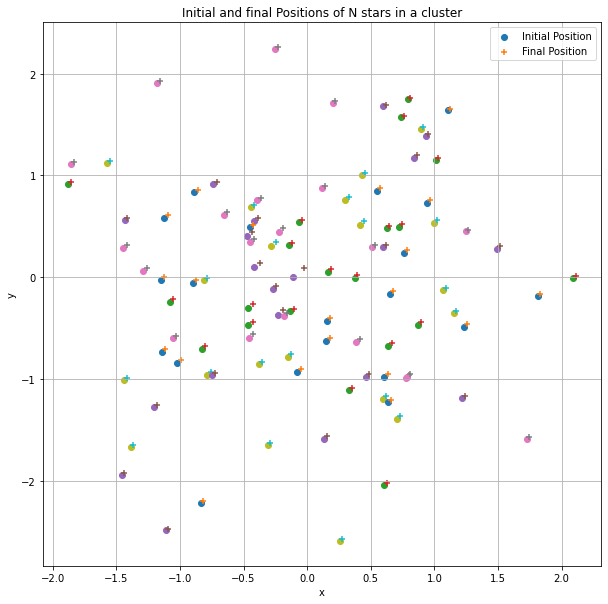

In [59]:
plt.figure(figsize=(10,10))

for i in range(0, N):
    plt.scatter(r0[i][0], r0[i][1],label='Initial Position' if i==0 else"")
    plt.scatter(pos_correct[i][0], pos_correct[i][1], marker='+',label='Final Position'if i==0 else"")
    


plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.title('Initial and final Positions of N stars in a cluster')